In [1]:
!pip install arabic-reshaper
!pip install python-bidi
!pip install wordcloud
!pip install tashaphyne
!pip install pyarabic
!pip install wordcloud

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
import re
import string
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.model_selection import train_test_split
import pyarabic.araby as araby
from wordcloud import WordCloud
from sklearn.metrics import classification_report
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout,BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import SpatialDropout1D,Bidirectional,Dropout,Flatten,Embedding


In [4]:
df = pd.read_csv('/content/Dataset - Sheet1 (15).csv')

In [5]:
df

,id_case,type,full_text,summary
0,1,جنائية,الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ...,أقام المدعي العام دعواه ضد المدعى عليه طالباً ...
1,2,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
2,3,جنائية,الحمد لله وحده، والصلاة والسلام على من لا نبي ...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
3,4,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد الحدث المدعى عليه، ...
4,5,احوال,اليوم أطلب إلزامه بالنفقة الماضية على ابنتي هذ...,ادعت المدعية على المدعى عليه وكالة بأن موكله ت...
...,...,...,...,...
895,896,احوال,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...
896,897,احوال,الحمد لله وحده وبعد فلدي أنا .... مساعد رئيس ...,ادعى وكيلا المدعين بأن مورثهم خلف من ضمن تركت...
897,898,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي ضد المدعى عليهم بأن مورثهم خلف عما...
898,899,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي بأنه كان زوجاً للمدعى عليها وقد تم...


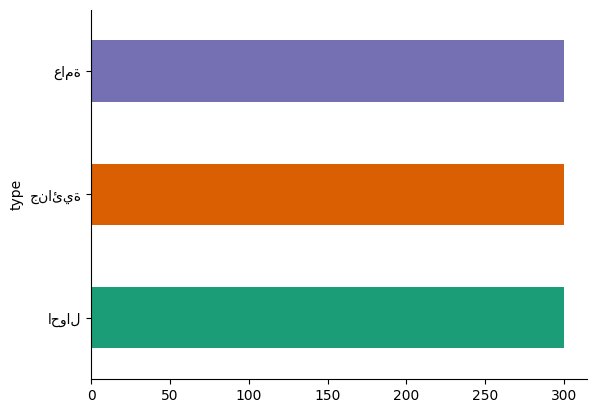

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-7-909b0fd27b61>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


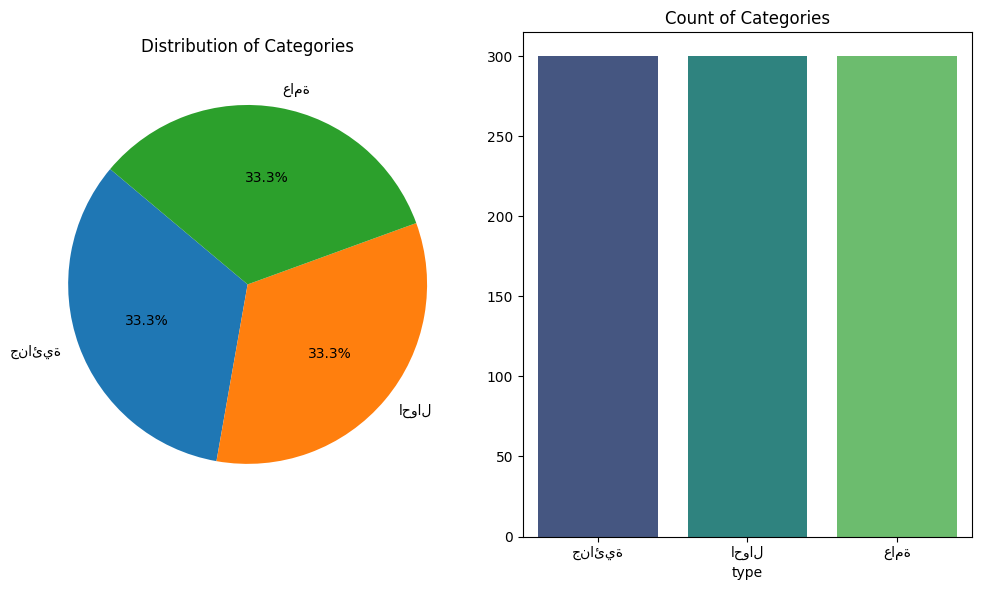

In [7]:
count = df['type'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(10, 6), facecolor='white')

palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

plt.tight_layout()

plt.show()

In [8]:
df.type.value_counts()

type
جنائية    300
احوال     300
عامة      300
Name: count, dtype: int64

In [9]:
df.shape

(900, 4)

In [10]:
df.columns

Index(['id_case', 'type', 'full_text', 'summary'], dtype='object')

In [11]:
df.dtypes

id_case       int64
type         object
full_text    object
summary      object
dtype: object

# EDA

In [12]:
df.head()

,id_case,type,full_text,summary
0,1,جنائية,الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ...,أقام المدعي العام دعواه ضد المدعى عليه طالباً ...
1,2,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
2,3,جنائية,الحمد لله وحده، والصلاة والسلام على من لا نبي ...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
3,4,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد الحدث المدعى عليه، ...
4,5,احوال,اليوم أطلب إلزامه بالنفقة الماضية على ابنتي هذ...,ادعت المدعية على المدعى عليه وكالة بأن موكله ت...


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_case    900 non-null    int64 
 1   type       900 non-null    object
 2   full_text  900 non-null    object
 3   summary    900 non-null    object
dtypes: int64(1), object(3)
memory usage: 28.2+ KB


In [14]:
df=df.drop(['id_case'],axis=1)
df

,type,full_text,summary
0,جنائية,الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ...,أقام المدعي العام دعواه ضد المدعى عليه طالباً ...
1,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
2,جنائية,الحمد لله وحده، والصلاة والسلام على من لا نبي ...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...
3,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد الحدث المدعى عليه، ...
4,احوال,اليوم أطلب إلزامه بالنفقة الماضية على ابنتي هذ...,ادعت المدعية على المدعى عليه وكالة بأن موكله ت...
...,...,...,...
895,احوال,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...
896,احوال,الحمد لله وحده وبعد فلدي أنا .... مساعد رئيس ...,ادعى وكيلا المدعين بأن مورثهم خلف من ضمن تركت...
897,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي ضد المدعى عليهم بأن مورثهم خلف عما...
898,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي بأنه كان زوجاً للمدعى عليها وقد تم...


In [15]:
df.isnull().sum()

type         0
full_text    0
summary      0
dtype: int64

In [16]:
df.full_text[0]

'الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ١٤٣٥هـ لدي أنا (...) القاضي بالمحكمة الجزائية بمحافظة القطيف افتتحت الجلسة في الساعة الحادية عشرة والنصف صباحاً بناء على المعاملة المحالة لنا من رئيس هذه المحكمة برقم ٣٤٥١٢٩٠٠ في ١١/١٣/ ١٤٣٤هـ والمقيدة لدى المحكمة بالقيد رقم ٣٤٢٥٩٨١٨٧ في ١١/١٣/ ١٤٣٤هـ وفي هذه الجلسة حضر المدعي العام (...) وقرر قائلاً : بصفتي مدعياً عاما في دائرة التحقيق والادعاء العام بمحافظة القطيف أدعي على : (...) ، البالغ من العمر (۳۲) عاماً، سعودي الجنسية بموجب السجل المدني رقم (...)، غير محصن، متسبب، أوقف بتاريخ ١٤٣٤/٨/٢٥ هـ وأفرج عنه بتاريخ ١٠/١١/ ١٤٣٤هـ استناداً للمادة (۱۲۰) من نظام الإجراءات الجزائية، ويقيم بمحافظة القطيف حيث إنه بتاريخ ١٤٣٣/٩/٢٧هـ وردت برقية مدير إدارة مباحث محافظة القطيف والموجهة لمدير شرطة محافظة القطيف برقم (٣٦٧٨) المتضمنة أنه توفرت معلومات عن المدعى عليه وشخصين آخرين أحدهما يدعى (...) والآخر يدعى (...)، يستخدمون الدرجات النارية وكذلك الأسلحة ببلدة (...)؛ ويقومون بتخويف المارة، ولهم علاقة بمثيري الشغب في المحافظة وبتاريخ ١٤٣٤/٨/٢٥هـ قبض على الم

In [17]:
df.summary[0]

'أقام المدعي العام دعواه ضد المدعى عليه طالباً إثبات إدانته بالمشاركة في تجمعات ومسيرات بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات معادية ومحرّضة على البلاد، وطلب الحكم عليه بعقوبة تعزيرية، وبعرض الدعوى على المدعى عليه، أنكر صحتها، ودفع بأنه شارك في تشييع جنائز ، وبطلب البينة من المدعي العام استند إلى تسجيلات مرئية لمظاهرات، وإلى إقرار المدعى عليه تحقيقا المتضمن مشاركته فيها، وبعرضه عليه أقر بصدوره منه، ودفع بأنه لم يردد أي هتافات، وأن صورته غير ظاهرة في التسجيل، ولأن المدعي العام لم يقدم بينة على ترديد المدعى عليه لهتافات معادية للبلاد، ولأن مشاركة المدعى عليه في ثلاث مسيرات ينادى فيها بعبارات معادية ومحرضة على البلاد إقرار منه لما حصل فيها، ولا يعفيه من العقوبة عليها، لذا فقد ثبت لدى القاضي قيام المدعى عليه بالمشاركة في مسيرات جنائز بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات مسيئة ومعادية للدولة، ومحرضة على رجال الأمن، وحكم بسجنه لمدة ثلاثة أشهر، ومنعه من السفر خارج البلاد لمدة سنة، فاعترض الطرفان، وصدق الحكم من محكمة الاستئناف.'

In [18]:
df.duplicated().sum()

0

In [19]:
eda=df.copy()
stop = stopwords.words('arabic')

eda['Number_of_words_full_text'] = eda['full_text'].apply(lambda x: len(str(x).split(" ")))
eda['Number_of_charfull_text'] = eda['full_text'].str.len()
eda['stopwords_full_text'] = eda['full_text'].apply(lambda x: len([x for x in x.split() if x in stop]))


eda['Number_of_words_summary'] = eda['summary'].apply(lambda x: len(str(x).split(" ")))
eda['Number_of_char_summary'] = eda['summary'].str.len()
eda['stopwords_summary'] = eda['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))

eda.head()

,type,full_text,summary,Number_of_words_full_text,Number_of_charfull_text,stopwords_full_text,Number_of_words_summary,Number_of_char_summary,stopwords_summary
0,جنائية,الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ...,أقام المدعي العام دعواه ضد المدعى عليه طالباً ...,1603,9115,332,167,985,37
1,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...,1218,6935,253,167,969,39
2,جنائية,الحمد لله وحده، والصلاة والسلام على من لا نبي ...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...,1046,5979,192,98,564,15
3,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد الحدث المدعى عليه، ...,836,4778,145,102,586,21
4,احوال,اليوم أطلب إلزامه بالنفقة الماضية على ابنتي هذ...,ادعت المدعية على المدعى عليه وكالة بأن موكله ت...,427,2358,98,154,819,42


# pre-processing

In [20]:
def remove_numbers(text):
    cleaned_text = re.sub(r'\d+', '', text)
    return cleaned_text

df['cleaned_text'] = df['full_text'].apply(remove_numbers)
df['cleaned_summary'] = df['summary'].apply(remove_numbers)

In [21]:
df['cleaned_text'][0]

'الحمد لله وحده، وبعد: وفي يوم الاثنين  /  / هـ لدي أنا (...) القاضي بالمحكمة الجزائية بمحافظة القطيف افتتحت الجلسة في الساعة الحادية عشرة والنصف صباحاً بناء على المعاملة المحالة لنا من رئيس هذه المحكمة برقم  في // هـ والمقيدة لدى المحكمة بالقيد رقم  في // هـ وفي هذه الجلسة حضر المدعي العام (...) وقرر قائلاً : بصفتي مدعياً عاما في دائرة التحقيق والادعاء العام بمحافظة القطيف أدعي على : (...) ، البالغ من العمر () عاماً، سعودي الجنسية بموجب السجل المدني رقم (...)، غير محصن، متسبب، أوقف بتاريخ // هـ وأفرج عنه بتاريخ // هـ استناداً للمادة () من نظام الإجراءات الجزائية، ويقيم بمحافظة القطيف حيث إنه بتاريخ //هـ وردت برقية مدير إدارة مباحث محافظة القطيف والموجهة لمدير شرطة محافظة القطيف برقم () المتضمنة أنه توفرت معلومات عن المدعى عليه وشخصين آخرين أحدهما يدعى (...) والآخر يدعى (...)، يستخدمون الدرجات النارية وكذلك الأسلحة ببلدة (...)؛ ويقومون بتخويف المارة، ولهم علاقة بمثيري الشغب في المحافظة وبتاريخ //هـ قبض على المدعى عليه من قبل جوازات منفذ (...) وأحيل لشرطة محافظة القطيف، والتي بدورها أحا

In [22]:
df['cleaned_summary'][0]

'أقام المدعي العام دعواه ضد المدعى عليه طالباً إثبات إدانته بالمشاركة في تجمعات ومسيرات بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات معادية ومحرّضة على البلاد، وطلب الحكم عليه بعقوبة تعزيرية، وبعرض الدعوى على المدعى عليه، أنكر صحتها، ودفع بأنه شارك في تشييع جنائز ، وبطلب البينة من المدعي العام استند إلى تسجيلات مرئية لمظاهرات، وإلى إقرار المدعى عليه تحقيقا المتضمن مشاركته فيها، وبعرضه عليه أقر بصدوره منه، ودفع بأنه لم يردد أي هتافات، وأن صورته غير ظاهرة في التسجيل، ولأن المدعي العام لم يقدم بينة على ترديد المدعى عليه لهتافات معادية للبلاد، ولأن مشاركة المدعى عليه في ثلاث مسيرات ينادى فيها بعبارات معادية ومحرضة على البلاد إقرار منه لما حصل فيها، ولا يعفيه من العقوبة عليها، لذا فقد ثبت لدى القاضي قيام المدعى عليه بالمشاركة في مسيرات جنائز بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات مسيئة ومعادية للدولة، ومحرضة على رجال الأمن، وحكم بسجنه لمدة ثلاثة أشهر، ومنعه من السفر خارج البلاد لمدة سنة، فاعترض الطرفان، وصدق الحكم من محكمة الاستئناف.'

In [23]:
def Removing_non_arabic(text):
    text =re.sub(r'[^0-9\u0600-\u06ff\u0750-\u077f\ufb50-\ufbc1\ufbd3-\ufd3f\ufd50-\ufd8f\ufd50-\ufd8f\ufe70-\ufefc\uFDF0-\uFDFD.0-9٠-٩]+', ' ',text)
    return text

In [24]:
df['cleaned_text'] = df['cleaned_text'].apply(Removing_non_arabic)
df['cleaned_summary'] = df['cleaned_summary'].apply(Removing_non_arabic)

In [25]:
df['cleaned_text'][0]

'الحمد لله وحده، وبعد وفي يوم الاثنين هـ لدي أنا ... القاضي بالمحكمة الجزائية بمحافظة القطيف افتتحت الجلسة في الساعة الحادية عشرة والنصف صباحاً بناء على المعاملة المحالة لنا من رئيس هذه المحكمة برقم في هـ والمقيدة لدى المحكمة بالقيد رقم في هـ وفي هذه الجلسة حضر المدعي العام ... وقرر قائلاً بصفتي مدعياً عاما في دائرة التحقيق والادعاء العام بمحافظة القطيف أدعي على ... ، البالغ من العمر عاماً، سعودي الجنسية بموجب السجل المدني رقم ... ، غير محصن، متسبب، أوقف بتاريخ هـ وأفرج عنه بتاريخ هـ استناداً للمادة من نظام الإجراءات الجزائية، ويقيم بمحافظة القطيف حيث إنه بتاريخ هـ وردت برقية مدير إدارة مباحث محافظة القطيف والموجهة لمدير شرطة محافظة القطيف برقم المتضمنة أنه توفرت معلومات عن المدعى عليه وشخصين آخرين أحدهما يدعى ... والآخر يدعى ... ، يستخدمون الدرجات النارية وكذلك الأسلحة ببلدة ... ؛ ويقومون بتخويف المارة، ولهم علاقة بمثيري الشغب في المحافظة وبتاريخ هـ قبض على المدعى عليه من قبل جوازات منفذ ... وأحيل لشرطة محافظة القطيف، والتي بدورها أحالته للمباحث العامة بالمنطقة الشرقية، وبسماع أقواله 

In [26]:
df['cleaned_summary'][0]

'أقام المدعي العام دعواه ضد المدعى عليه طالباً إثبات إدانته بالمشاركة في تجمعات ومسيرات بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات معادية ومحرّضة على البلاد، وطلب الحكم عليه بعقوبة تعزيرية، وبعرض الدعوى على المدعى عليه، أنكر صحتها، ودفع بأنه شارك في تشييع جنائز ، وبطلب البينة من المدعي العام استند إلى تسجيلات مرئية لمظاهرات، وإلى إقرار المدعى عليه تحقيقا المتضمن مشاركته فيها، وبعرضه عليه أقر بصدوره منه، ودفع بأنه لم يردد أي هتافات، وأن صورته غير ظاهرة في التسجيل، ولأن المدعي العام لم يقدم بينة على ترديد المدعى عليه لهتافات معادية للبلاد، ولأن مشاركة المدعى عليه في ثلاث مسيرات ينادى فيها بعبارات معادية ومحرضة على البلاد إقرار منه لما حصل فيها، ولا يعفيه من العقوبة عليها، لذا فقد ثبت لدى القاضي قيام المدعى عليه بالمشاركة في مسيرات جنائز بها إثارة وتأليب للرأي العام والنعرة الطائفية، وتردد بها هتافات مسيئة ومعادية للدولة، ومحرضة على رجال الأمن، وحكم بسجنه لمدة ثلاثة أشهر، ومنعه من السفر خارج البلاد لمدة سنة، فاعترض الطرفان، وصدق الحكم من محكمة الاستئناف.'

In [27]:
ara_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
stop_words = stopwords.words()

def remove_punctuations(text):

    translator = str.maketrans('', '', ara_punctuations)
    text = text.translate(translator)

    return text


df['cleaned_text'] = df['cleaned_text'].apply(remove_punctuations)
df['cleaned_summary'] = df['cleaned_summary'].apply(remove_punctuations)

In [28]:
df['cleaned_text'][0]

'الحمد لله وحده وبعد وفي يوم الاثنين ه لدي أنا  القاضي بالمحكمة الجزائية بمحافظة القطيف افتتحت الجلسة في الساعة الحادية عشرة والنصف صباحاً بناء على المعاملة المحالة لنا من رئيس هذه المحكمة برقم في ه والمقيدة لدى المحكمة بالقيد رقم في ه وفي هذه الجلسة حضر المدعي العام  وقرر قائلاً بصفتي مدعياً عاما في دائرة التحقيق والادعاء العام بمحافظة القطيف أدعي على   البالغ من العمر عاماً سعودي الجنسية بموجب السجل المدني رقم   غير محصن متسبب أوقف بتاريخ ه وأفرج عنه بتاريخ ه استناداً للمادة من نظام الإجراءات الجزائية ويقيم بمحافظة القطيف حيث إنه بتاريخ ه وردت برقية مدير إدارة مباحث محافظة القطيف والموجهة لمدير شرطة محافظة القطيف برقم المتضمنة أنه توفرت معلومات عن المدعى عليه وشخصين آخرين أحدهما يدعى  والآخر يدعى   يستخدمون الدرجات النارية وكذلك الأسلحة ببلدة   ويقومون بتخويف المارة ولهم علاقة بمثيري الشغب في المحافظة وبتاريخ ه قبض على المدعى عليه من قبل جوازات منفذ  وأحيل لشرطة محافظة القطيف والتي بدورها أحالته للمباحث العامة بالمنطقة الشرقية وبسماع أقواله الأولية من قبل ضابط خفر شعبة التحريات والبح

In [29]:
df['cleaned_summary'][0]

'أقام المدعي العام دعواه ضد المدعى عليه طالباً إثبات إدانته بالمشاركة في تجمعات ومسيرات بها إثارة وتأليب للرأي العام والنعرة الطائفية وتردد بها هتافات معادية ومحرّضة على البلاد وطلب الحكم عليه بعقوبة تعزيرية وبعرض الدعوى على المدعى عليه أنكر صحتها ودفع بأنه شارك في تشييع جنائز  وبطلب البينة من المدعي العام استند إلى تسجيلات مرئية لمظاهرات وإلى إقرار المدعى عليه تحقيقا المتضمن مشاركته فيها وبعرضه عليه أقر بصدوره منه ودفع بأنه لم يردد أي هتافات وأن صورته غير ظاهرة في التسجيل ولأن المدعي العام لم يقدم بينة على ترديد المدعى عليه لهتافات معادية للبلاد ولأن مشاركة المدعى عليه في ثلاث مسيرات ينادى فيها بعبارات معادية ومحرضة على البلاد إقرار منه لما حصل فيها ولا يعفيه من العقوبة عليها لذا فقد ثبت لدى القاضي قيام المدعى عليه بالمشاركة في مسيرات جنائز بها إثارة وتأليب للرأي العام والنعرة الطائفية وتردد بها هتافات مسيئة ومعادية للدولة ومحرضة على رجال الأمن وحكم بسجنه لمدة ثلاثة أشهر ومنعه من السفر خارج البلاد لمدة سنة فاعترض الطرفان وصدق الحكم من محكمة الاستئناف'

In [30]:
arabic_stopwords = stopwords.words("arabic")
len(arabic_stopwords)

754

In [31]:
arabic_stopwords


['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [32]:
def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in arabic_stopwords]
    return " ".join(Text)

df['cleaned_text'] = df['cleaned_text'].apply(remove_stop_words)
df['cleaned_summary'] = df['cleaned_summary'].apply(remove_stop_words)

In [33]:
df['cleaned_text'][0]

'الحمد لله وحده وبعد وفي يوم الاثنين لدي القاضي بالمحكمة الجزائية بمحافظة القطيف افتتحت الجلسة الساعة الحادية والنصف صباحاً بناء المعاملة المحالة رئيس المحكمة برقم والمقيدة المحكمة بالقيد رقم وفي الجلسة حضر المدعي العام وقرر قائلاً بصفتي مدعياً عاما دائرة التحقيق والادعاء العام بمحافظة القطيف أدعي البالغ العمر عاماً سعودي الجنسية بموجب السجل المدني رقم محصن متسبب أوقف بتاريخ وأفرج عنه بتاريخ استناداً للمادة نظام الإجراءات الجزائية ويقيم بمحافظة القطيف بتاريخ وردت برقية مدير إدارة مباحث محافظة القطيف والموجهة لمدير شرطة محافظة القطيف برقم المتضمنة أنه توفرت معلومات المدعى وشخصين آخرين أحدهما يدعى والآخر يدعى يستخدمون الدرجات النارية وكذلك الأسلحة ببلدة ويقومون بتخويف المارة ولهم علاقة بمثيري الشغب المحافظة وبتاريخ قبض المدعى جوازات منفذ وأحيل لشرطة محافظة القطيف والتي بدورها أحالته للمباحث العامة بالمنطقة الشرقية وبسماع أقواله الأولية ضابط خفر شعبة التحريات والبحث الجنائي بشرطة محافظة القطيف أقر أنه شارك تشييع جثمان القتيلان المواجهات المسلحة رجال الأمن أقر بوجوده بالعوامية أثناء تشييع 

In [34]:
df['cleaned_summary'][0]

'أقام المدعي العام دعواه ضد المدعى طالباً إثبات إدانته بالمشاركة تجمعات ومسيرات إثارة وتأليب للرأي العام والنعرة الطائفية وتردد هتافات معادية ومحرّضة البلاد وطلب الحكم بعقوبة تعزيرية وبعرض الدعوى المدعى أنكر صحتها ودفع بأنه شارك تشييع جنائز وبطلب البينة المدعي العام استند تسجيلات مرئية لمظاهرات وإلى إقرار المدعى تحقيقا المتضمن مشاركته وبعرضه أقر بصدوره ودفع بأنه يردد هتافات وأن صورته ظاهرة التسجيل ولأن المدعي العام يقدم بينة ترديد المدعى لهتافات معادية للبلاد ولأن مشاركة المدعى مسيرات ينادى بعبارات معادية ومحرضة البلاد إقرار حصل يعفيه العقوبة عليها لذا فقد ثبت القاضي قيام المدعى بالمشاركة مسيرات جنائز إثارة وتأليب للرأي العام والنعرة الطائفية وتردد هتافات مسيئة ومعادية للدولة ومحرضة رجال الأمن وحكم بسجنه لمدة أشهر ومنعه السفر خارج البلاد لمدة سنة فاعترض الطرفان وصدق الحكم محكمة الاستئناف'

In [35]:
def remove_tashkeel(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text)
    return araby.strip_tashkeel(text)

In [36]:
df['cleaned_text'] = df['cleaned_text'].apply(remove_tashkeel)
df['cleaned_summary'] = df['cleaned_summary'].apply(remove_tashkeel)

In [37]:
df['cleaned_text'][0]

'الحمد لله وحده وبعد وفي يوم الاثنين لدي القاضي بالمحكمه الجزاءيه بمحافظه القطيف افتتحت الجلسه الساعه الحاديه والنصف صباحا بناء المعامله المحاله رءيس المحكمه برقم والمقيده المحكمه بالقيد رقم وفي الجلسه حضر المدعي العام وقرر قاءلا بصفتي مدعيا عاما داءره التحقيق والادعاء العام بمحافظه القطيف ادعي البالغ العمر عاما سعودي الجنسيه بموجب السجل المدني رقم محصن متسبب اوقف بتاريخ وافرج عنه بتاريخ استنادا للماده نظام الاجراءات الجزاءيه ويقيم بمحافظه القطيف بتاريخ وردت برقيه مدير اداره مباحث محافظه القطيف والموجهه لمدير شرطه محافظه القطيف برقم المتضمنه انه توفرت معلومات المدعي وشخصين اخرين احدهما يدعي والاخر يدعي يستخدمون الدرجات الناريه وكذلك الاسلحه ببلده ويقومون بتخويف الماره ولهم علاقه بمثيري الشغب المحافظه وبتاريخ قبض المدعي جوازات منفذ واحيل لشرطه محافظه القطيف والتي بدورها احالته للمباحث العامه بالمنطقه الشرقيه وبسماع اقواله الاوليه ضابط خفر شعبه التحريات والبحث الجناءي بشرطه محافظه القطيف اقر انه شارك تشييع جثمان القتيلان المواجهات المسلحه رجال الامن اقر بوجوده بالعواميه اثناء تشييع قتلي 

In [38]:
df['cleaned_summary'][0]

'اقام المدعي العام دعواه ضد المدعي طالبا اثبات ادانته بالمشاركه تجمعات ومسيرات اثاره وتاليب للراي العام والنعره الطاءفيه وتردد هتافات معاديه ومحرضه البلاد وطلب الحكم بعقوبه تعزيريه وبعرض الدعوي المدعي انكر صحتها ودفع بانه شارك تشييع جناءز وبطلب البينه المدعي العام استند تسجيلات مرءيه لمظاهرات والي اقرار المدعي تحقيقا المتضمن مشاركته وبعرضه اقر بصدوره ودفع بانه يردد هتافات وان صورته ظاهره التسجيل ولان المدعي العام يقدم بينه ترديد المدعي لهتافات معاديه للبلاد ولان مشاركه المدعي مسيرات ينادي بعبارات معاديه ومحرضه البلاد اقرار حصل يعفيه العقوبه عليها لذا فقد ثبت القاضي قيام المدعي بالمشاركه مسيرات جناءز اثاره وتاليب للراي العام والنعره الطاءفيه وتردد هتافات مسيءه ومعاديه للدوله ومحرضه رجال الامن وحكم بسجنه لمده اشهر ومنعه السفر خارج البلاد لمده سنه فاعترض الطرفان وصدق الحكم محكمه الاستءناف'

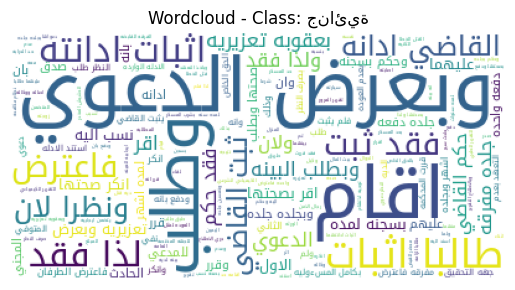

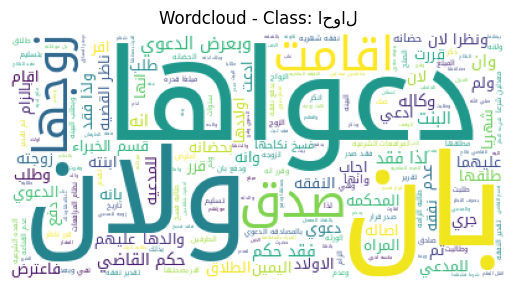

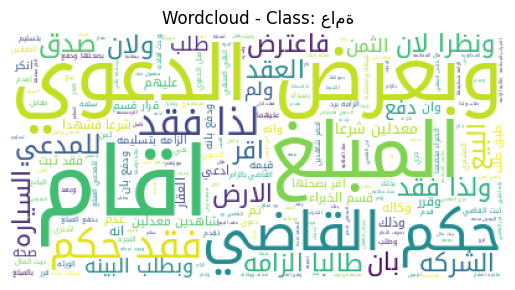

In [39]:
classes = df["type"].unique()


custom_stopwords = ["المدعى", "المدعي", "الجنسية", "بموجب", "السجل", "المدني", "بتاريخ", "المدعية", "الجلسة", "وتاريخ", "وقد", "نبينا", "العام", "حضر", "رقم", "حمد لله", "و صلى ", "المحكمة", "العامة", "سعودي", "برقم", "موكلي", "الوكالة", "عليها", "وحده", "الحمد", "لله", "وكالة", "الدعوى", "وبالله", "التوفيق", "وصحبه", "وسلم", "حرر", "في", "قال", "جاء", "ذكره",
 "أنه", "محمد", "الرقم", "المذكور", "السجل", "محكمة", "الاستئناف", "وصدق", "الحكم", "دعواه", "ولأن", "ضد", "أقام", "علي", "محكمه", "المدعيه", "الاستءناف"]

for class_name in classes:
    class_text = " ".join(df[df["type"] == class_name]["cleaned_summary"].astype(str).tolist())

    wordcloud = WordCloud(font_path='/content/NotoKufiArabic-Regular.ttf',
                          stopwords=stop_words + custom_stopwords,
                          background_color="white").generate(class_text)

    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Wordcloud - Class: " + class_name)
    plt.show()

In [40]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

In [41]:
df.cleaned_text=df.cleaned_text.apply(lambda text : tokenize_text(text))
df.cleaned_summary=df.cleaned_summary.apply(lambda text : tokenize_text(text))

In [42]:
df['cleaned_text'][0]

['الحمد',
 'لله',
 'وحده',
 'وبعد',
 'وفي',
 'يوم',
 'الاثنين',
 'لدي',
 'القاضي',
 'بالمحكمه',
 'الجزاءيه',
 'بمحافظه',
 'القطيف',
 'افتتحت',
 'الجلسه',
 'الساعه',
 'الحاديه',
 'والنصف',
 'صباحا',
 'بناء',
 'المعامله',
 'المحاله',
 'رءيس',
 'المحكمه',
 'برقم',
 'والمقيده',
 'المحكمه',
 'بالقيد',
 'رقم',
 'وفي',
 'الجلسه',
 'حضر',
 'المدعي',
 'العام',
 'وقرر',
 'قاءلا',
 'بصفتي',
 'مدعيا',
 'عاما',
 'داءره',
 'التحقيق',
 'والادعاء',
 'العام',
 'بمحافظه',
 'القطيف',
 'ادعي',
 'البالغ',
 'العمر',
 'عاما',
 'سعودي',
 'الجنسيه',
 'بموجب',
 'السجل',
 'المدني',
 'رقم',
 'محصن',
 'متسبب',
 'اوقف',
 'بتاريخ',
 'وافرج',
 'عنه',
 'بتاريخ',
 'استنادا',
 'للماده',
 'نظام',
 'الاجراءات',
 'الجزاءيه',
 'ويقيم',
 'بمحافظه',
 'القطيف',
 'بتاريخ',
 'وردت',
 'برقيه',
 'مدير',
 'اداره',
 'مباحث',
 'محافظه',
 'القطيف',
 'والموجهه',
 'لمدير',
 'شرطه',
 'محافظه',
 'القطيف',
 'برقم',
 'المتضمنه',
 'انه',
 'توفرت',
 'معلومات',
 'المدعي',
 'وشخصين',
 'اخرين',
 'احدهما',
 'يدعي',
 'والاخر',
 'يدعي',
 'يستخدمون'

In [43]:
df['cleaned_summary'][0]

['اقام',
 'المدعي',
 'العام',
 'دعواه',
 'ضد',
 'المدعي',
 'طالبا',
 'اثبات',
 'ادانته',
 'بالمشاركه',
 'تجمعات',
 'ومسيرات',
 'اثاره',
 'وتاليب',
 'للراي',
 'العام',
 'والنعره',
 'الطاءفيه',
 'وتردد',
 'هتافات',
 'معاديه',
 'ومحرضه',
 'البلاد',
 'وطلب',
 'الحكم',
 'بعقوبه',
 'تعزيريه',
 'وبعرض',
 'الدعوي',
 'المدعي',
 'انكر',
 'صحتها',
 'ودفع',
 'بانه',
 'شارك',
 'تشييع',
 'جناءز',
 'وبطلب',
 'البينه',
 'المدعي',
 'العام',
 'استند',
 'تسجيلات',
 'مرءيه',
 'لمظاهرات',
 'والي',
 'اقرار',
 'المدعي',
 'تحقيقا',
 'المتضمن',
 'مشاركته',
 'وبعرضه',
 'اقر',
 'بصدوره',
 'ودفع',
 'بانه',
 'يردد',
 'هتافات',
 'وان',
 'صورته',
 'ظاهره',
 'التسجيل',
 'ولان',
 'المدعي',
 'العام',
 'يقدم',
 'بينه',
 'ترديد',
 'المدعي',
 'لهتافات',
 'معاديه',
 'للبلاد',
 'ولان',
 'مشاركه',
 'المدعي',
 'مسيرات',
 'ينادي',
 'بعبارات',
 'معاديه',
 'ومحرضه',
 'البلاد',
 'اقرار',
 'حصل',
 'يعفيه',
 'العقوبه',
 'عليها',
 'لذا',
 'فقد',
 'ثبت',
 'القاضي',
 'قيام',
 'المدعي',
 'بالمشاركه',
 'مسيرات',
 'جناءز',
 'اثاره',
 'وت

In [44]:
def Arabic_Light_Stemmer(text):

    Arabic_Stemmer = ArabicLightStemmer()
    text=[Arabic_Stemmer.light_stem(y) for y in text]

    return " " .join(text)

df['Stemmed_text'] = df['cleaned_text'].apply(Arabic_Light_Stemmer)
df['Stemmed_summary'] = df['cleaned_summary'].apply(Arabic_Light_Stemmer)

In [45]:
df['Stemmed_text'][0]

'حمد له حد بعد في وم اثن لدى قاض محكمه جزاءيه محافظ قطيف افتتح جلسه ساعه حاديه نصف صباح ناء معامله محاله رءيس محكمه رقم مقيده محكمه قيد رقم في جلسه حضر مدع عام قرر قاءل صف مدعي عام داءر تحقيق ادعاء عام محافظ قطيف دع بالغ عمر عام سعود جنسيه موجب سجل مدن رقم محص متسبب وقف تاريخ فرج عن تاريخ ستناد ماده ظام اجراء جزاءيه قيم محافظ قطيف تاريخ رد رق مدير دار مباحث محافظ قطيف موجهه مدير شرط محافظ قطيف رقم متضمنه نه وفرت معلوم مدع شخص خري حد دعي اخر دعي يستخدم درج ناريه كذلك اسلحه بلد قوم تخويف ماره هم علاق مثير شغب محافظه تاريخ قبض مدع جواز منفذ حيل شرط محافظ قطيف التي دور حالت مباحث عامه منطقه شرقيه سماع قوال اوليه ضابط خفر شعب تحر بحث جناء شرط محافظ قطيف قر نه شار شييع جثم قتيل مواجه مسلحه رجال امن قر وجود عواميه اثناء شييع قتل مواجه مسلحه رجال امن مطلوب سابق جه امنيه نه قف اثناء شييع استجواب شان استخدام اسلحه علاق مثير شغب محافظ قطيف قر نه شار شييع جناز شخاص قتل مواجه مسلحه رجال امن هم جر حفظ اتهام حق جه تحقيق خص استخدام اسلحه احال هيء تحقيق ادعاء عام فاد نه شار شييع جناز قتل مواجه مسلحه دع

In [46]:
df['Stemmed_summary'][0]

'قام مدع عام دعوا ضد مدع طالب ثبات ادان مشاركه تجمع مسير ثار تاليب را عام نعره طاءفيه ردد هتاف معاد محرض بلاد طلب حكم عقوب عزير عرض دعو مدع نكر صح دفع ان شار شييع جناءز طلب بينه مدع عام ستند تسجيل مرء مظاهر لي قرار مدع حقيق متضمن مشارك عرض قر صدور دفع ان ردد هتاف ان صور ظاهر تسجيل ان مدع عام قدم بين رديد مدع هتاف معاد بلاد ان مشارك مدع مسير نادي عبار معاد محرض بلاد قرار حصل عفي عقوبه على ذا قد ثب قاض قيام مدع مشاركه مسير جناءز ثار تاليب را عام نعره طاءفيه ردد هتاف مسيء معاد دوله محرض رجال امن حكم سجن مد شهر منع سفر خارج بلاد مد سن عترض طرف صدق حكم محكم استءناف'

In [47]:
df

,type,full_text,summary,cleaned_text,cleaned_summary,Stemmed_text,Stemmed_summary
0,جنائية,الحمد لله وحده، وبعد: وفي يوم الاثنين ١ / ١ / ...,أقام المدعي العام دعواه ضد المدعى عليه طالباً ...,"[الحمد, لله, وحده, وبعد, وفي, يوم, الاثنين, لد...","[اقام, المدعي, العام, دعواه, ضد, المدعي, طالبا...",حمد له حد بعد في وم اثن لدى قاض محكمه جزاءيه م...,قام مدع عام دعوا ضد مدع طالب ثبات ادان مشاركه ...
1,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...,"[الحمد, لله, وحده, وبعد, فلدي, القاضي, المحكمه...","[اقام, المدعي, العام, دعواه, ضد, المدعي, طالبا...",حمد له حد بعد لدى قاض محكمه جزاءيه محافظ قطيف ...,قام مدع عام دعوا ضد مدع طالب ثبات ادان خروج طا...
2,جنائية,الحمد لله وحده، والصلاة والسلام على من لا نبي ...,أقام المدعي العام دعواه ضد المدعى عليه، طالباً...,"[الحمد, لله, وحده, والصلاه, والسلام, نبي, بعده...","[اقام, المدعي, العام, دعواه, ضد, المدعي, طالبا...",حمد له حد صلاه سلام بي بعد بعد لدى قاض محكمه ج...,قام مدع عام دعوا ضد مدع طالب ثبات ادان خروج طا...
3,جنائية,الحمد لله وحده، وبعد: فلدي أنا (...) القاضي في...,أقام المدعي العام دعواه ضد الحدث المدعى عليه، ...,"[الحمد, لله, وحده, وبعد, فلدي, القاضي, المحكمه...","[اقام, المدعي, العام, دعواه, ضد, الحدث, المدعي...",حمد له حد بعد لدى قاض محكمه جزاءيه بريد ناء مع...,قام مدع عام دعوا ضد حدث مدع طالب ثبات ادان مشا...
4,احوال,اليوم أطلب إلزامه بالنفقة الماضية على ابنتي هذ...,ادعت المدعية على المدعى عليه وكالة بأن موكله ت...,"[اليوم, اطلب, الزامه, بالنفقه, الماضيه, ابنتي,...","[ادعت, المدعيه, المدعي, وكاله, بان, موكله, تزو...",يوم طلب زامه نفقه ماضيه ابن دعو عرض ماجاء دعو ...,دعت مدعيه مدع ال ان موكل زوج طلق انجب طفل نه ت...
...,...,...,...,...,...,...,...
895,احوال,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...,\nطلب المدعي إلزام الجهة المدعى عليها بإعادة ا...,"[طلب, المدعي, الزام, الجهه, المدعي, عليها, باع...","[طلب, المدعي, الزام, الجهه, المدعي, عليها, باع...",طلب مدع زام جهه مدع على اعاد نظاره وقاف اغو مد...,طلب مدع زام جهه مدع على اعاد نظاره وقاف اغو مد...
896,احوال,الحمد لله وحده وبعد فلدي أنا .... مساعد رئيس ...,ادعى وكيلا المدعين بأن مورثهم خلف من ضمن تركت...,"[الحمد, لله, وحده, وبعد, فلدي, مساعد, رءيس, ال...","[ادعي, وكيلا, المدعين, بان, مورثهم, ضمن, تركته...",حمد له حد بعد لدى مساعد رءيس محكمه عامه مدينه ...,دع يلا مدع ان مورث ضمن ترك عد عقار موصوف دعوا ...
897,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي ضد المدعى عليهم بأن مورثهم خلف عما...,"[الحمد, لله, وحده, وبعد, فلدي, القاضي, المحكمه...","[ادعي, المدعي, ضد, المدعي, عليهم, بان, مورثهم,...",حمد له حد بعد لدى قاض محكمه عامه رياض ناء معام...,دع مدع ضد مدع على ان مورث عمار ستراح اع مدع عل...
898,احوال,الحمد لله وحده وبعد فلدي أنا القاضي في المحكمة...,ادعى المدعي بأنه كان زوجاً للمدعى عليها وقد تم...,"[الحمد, لله, وحده, وبعد, فلدي, القاضي, المحكمه...","[ادعي, المدعي, بانه, زوجا, للمدعي, عليها, وقد,...",حمد له حد بعد لدى قاض محكمه عامه محافظ جد ناء ...,دع مدع ان زوج مدع على قد تم سخ نكاح بين دخول م...


# Modeling

Diagram outlining the steps involved in sentiment analysis using deep learning model :

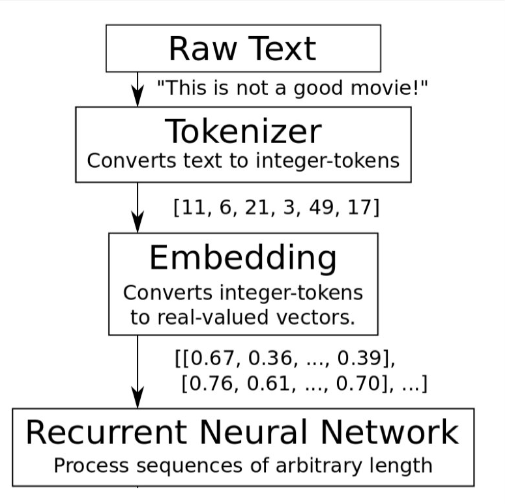

# LSTM


***LSTMs*** are a type of neural network specifically made for NLP (text-related) tasks. In fact, LSTMs are a specific type of RNN. An RNN is a type of neural network that has a sense of direction (sequence). Classic neural networks look at all inputs at the same level, but RNNs look at inputs in a sequential order, which works well for text, as it is a sequential form of input.

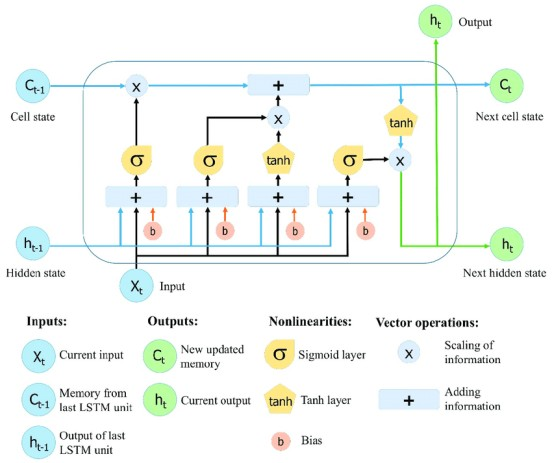

In [48]:
texts = df['Stemmed_text']
labels = df['type']

In [49]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size  = ", vocab_size)

max_sequence_length = 0
# Iterate over each text sample
for sent in texts:
    words = sent.split()
    if len(words) > max_sequence_length:
        max_sequence_length = len(words)
print("Max Sequence Length:", max_sequence_length)

# Convert texts to padded sequences
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

Vocabulary size  =  10866
Max Sequence Length: 5253


In [50]:
print(len(padded_sequences))
print(len(categorical_labels))
padded_sequences[0]
categorical_labels[0]

900
900


array([0., 1., 0.], dtype=float32)

In [51]:
#60-20-20
x, x_test, y, y_test = train_test_split(padded_sequences, categorical_labels,test_size=0.2,train_size=0.8,random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,train_size =0.75,random_state=42)

In [52]:
print(x_train.shape, x_val.shape, x_test.shape)

(540, 5253) (180, 5253) (180, 5253)


In [53]:
def plot_acc(history):
    plt.plot(history.history['accuracy'],color='red')
    plt.plot(history.history['val_accuracy'],color='orange')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [54]:
def plot_cm(model, X_test, y_test):

    products = ['0', '1', '2']

    pred = model.predict(X_test)

    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(pred, axis=1))


    counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    percent = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f"{v2}\n{v3}" for v2, v3 in zip(counts, percent)]
    labels = np.asarray(labels).reshape(3,3)

    plt.figure(figsize=(10,8))

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=labels, annot_kws={"size": 15}, fmt = '',
                xticklabels = products,
                yticklabels = products)

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12, rotation = 'horizontal')
    plt.title('Confusion Matrix\n', fontsize=19)
    plt.xlabel('Predicted Labels', fontsize=17)
    plt.ylabel('Actual Labels', fontsize=17)

Epoch 1/100
45/45 [==============================] - 15s 277ms/step - loss: 1.0973 - accuracy: 0.3630 - val_loss: 1.0979 - val_accuracy: 0.2944
Epoch 2/100
45/45 [==============================] - 11s 243ms/step - loss: 1.0868 - accuracy: 0.3778 - val_loss: 1.0905 - val_accuracy: 0.2889
Epoch 3/100
45/45 [==============================] - 11s 254ms/step - loss: 1.0254 - accuracy: 0.4759 - val_loss: 0.9412 - val_accuracy: 0.5111
Epoch 4/100
45/45 [==============================] - 11s 247ms/step - loss: 0.8062 - accuracy: 0.5944 - val_loss: 1.0267 - val_accuracy: 0.4389
Epoch 5/100
45/45 [==============================] - 10s 217ms/step - loss: 0.7638 - accuracy: 0.6315 - val_loss: 0.8417 - val_accuracy: 0.5167
Epoch 6/100
45/45 [==============================] - 11s 247ms/step - loss: 0.6276 - accuracy: 0.6852 - val_loss: 0.7299 - val_accuracy: 0.5667
Epoch 7/100
45/45 [==============================] - 11s 233ms/step - loss: 0.5676 - accuracy: 0.6907 - val_loss: 0.8236 - val_accuracy:

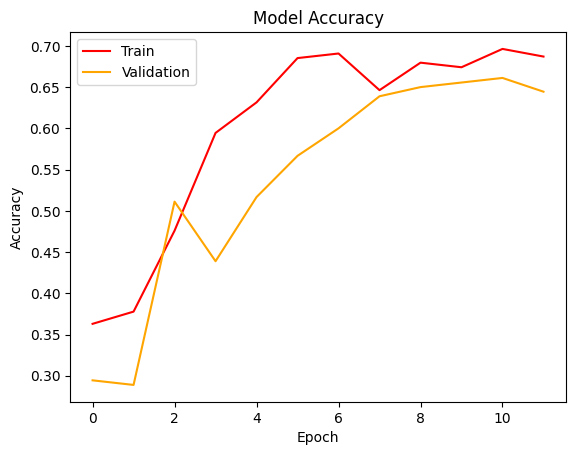

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5253, 300)         3259800   
                                                                 
 lstm_2 (LSTM)               (None, 10)                12440     
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 3272313 (12.48 MB)
Trainable params: 3272313 (12.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Test Loss: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [==============================] - 0s 78ms/step


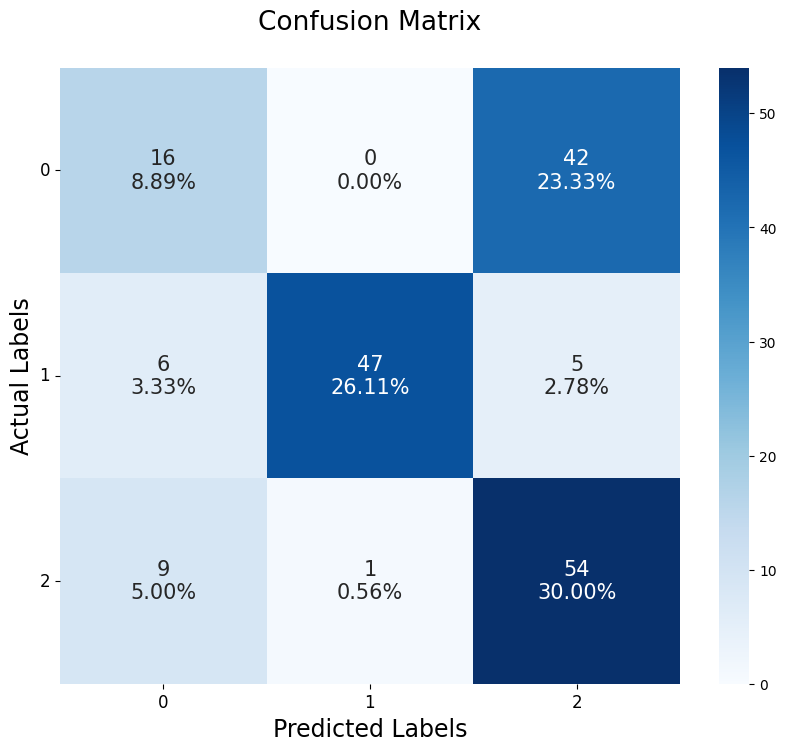

In [59]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

model_lstm1 = Sequential()
model_lstm1.add(Embedding(vocab_size, 300, input_length=max_sequence_length))
model_lstm1.add(LSTM(10, return_sequences=False))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(5, activation='relu'))
model_lstm1.add(Dense(3, activation='softmax'))

model_lstm1.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
history = model_lstm1.fit(x_train, y_train, batch_size= 12, epochs=100, validation_data=(x_val, y_val), verbose=1, callbacks=[early_stopping])

plot_acc(history)

model_lstm1.summary()

test_loss, test_accuracy = model_lstm1.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model_lstm1.predict(x_test)
y_pred = np.argmax(y_pred1, axis=1)


precision, recall, fscore, support = score(y_test, y_pred1.round())

print(sklearn.metrics.classification_report(y_test, y_pred1.round()))

plot_cm(model_lstm1, x_test, y_test)


In [60]:
model_lstm1.save("model_lstm1.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
from keras.models import load_model
model_new = tf.keras.models.load_model('model_lstm1.h5')

# GRU (Gated Recurrent Unit)

Similar to LSTM, GRU is specifically designed for modeling sequential data, enabling it to effectively retain or discard information over time. The primary distinction between GRU and LSTM is the way they handle the memory cell state. ***In LSTM***, the memory cell state is maintained separately from the hidden state and is updated using three gates:
*   Forget gate
*   Input gate
*   Output gate

***In GRU***, the memory cell state is replaced with a “candidate activation vector,” which is updated using two gates:
*   Reset gate
*   Update gate


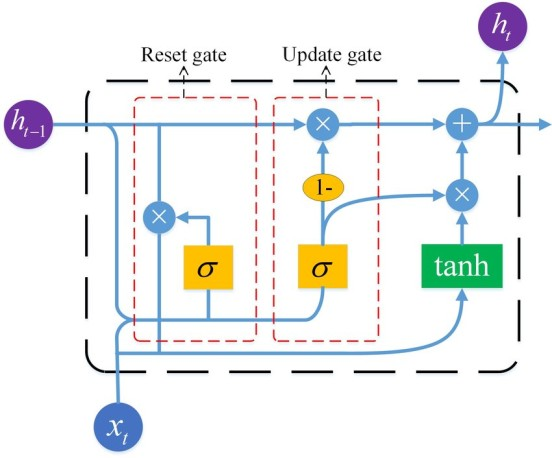

Epoch 1/100
90/90 [==============================] - 24s 235ms/step - loss: 1.1014 - accuracy: 0.3481 - val_loss: 1.0940 - val_accuracy: 0.3722
Epoch 2/100
90/90 [==============================] - 21s 231ms/step - loss: 1.0958 - accuracy: 0.4019 - val_loss: 1.0920 - val_accuracy: 0.4056
Epoch 3/100
90/90 [==============================] - 19s 213ms/step - loss: 1.0826 - accuracy: 0.4000 - val_loss: 1.0818 - val_accuracy: 0.4222
Epoch 4/100
90/90 [==============================] - 18s 204ms/step - loss: 1.0833 - accuracy: 0.4037 - val_loss: 1.0813 - val_accuracy: 0.4167
Epoch 5/100
90/90 [==============================] - 16s 177ms/step - loss: 1.0708 - accuracy: 0.4259 - val_loss: 1.0857 - val_accuracy: 0.4000
Epoch 6/100
90/90 [==============================] - 16s 178ms/step - loss: 1.0576 - accuracy: 0.4556 - val_loss: 1.0417 - val_accuracy: 0.4722
Epoch 7/100
90/90 [==============================] - 15s 172ms/step - loss: 0.8904 - accuracy: 0.5704 - val_loss: 0.8725 - val_accuracy:

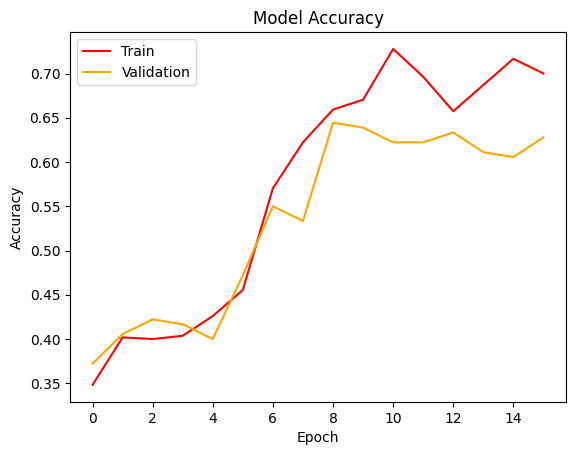

Test Loss: 0.6996626257896423
Test Accuracy: 0.5777778029441833
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 5253, 300)         3259800   
                                                                 
 gru_5 (GRU)                 (None, 10)                9360      
                                                                 
 dropout_8 (Dropout)         (None, 10)                0         
                                                                 
 dense_16 (Dense)            (None, 5)                 55        
                                                                 
 dense_17 (Dense)            (None, 3)                 18        
                                                                 
Total params: 3269233 (12.47 MB)
Trainable params: 3269233 (12.47 MB)
Non-trainable params: 0 (0.00 Byte)
________________

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [==============================] - 0s 71ms/step


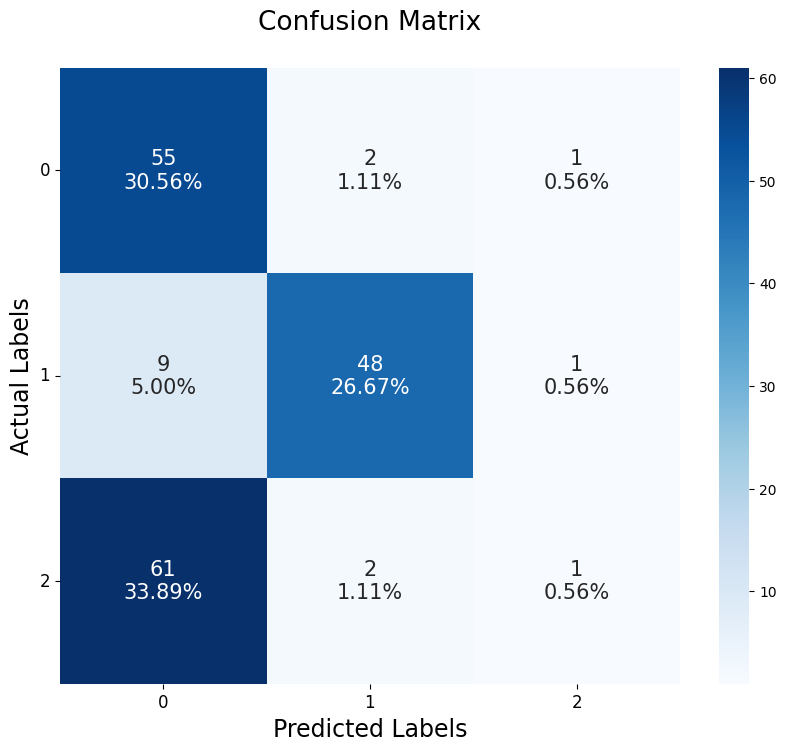

In [67]:
model_gru = Sequential()
model_gru.add(Embedding(vocab_size,300, input_length=max_sequence_length))
model_gru.add(GRU(units=10, return_sequences=False))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(5, activation='relu'))
model_gru.add(Dense(3, activation='softmax'))


model_gru.compile(optimizer=tf.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

history = model_gru.fit(x_train, y_train, batch_size=6, epochs=100, validation_data=(x_val, y_val), verbose=1, callbacks=[early_stopping])

y_pred = model_gru.predict(x_test, batch_size=12, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

plot_acc(history)


test_loss, test_accuracy = model_gru.evaluate(x_test, y_test, verbose=0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

model_gru.summary()

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model_gru.predict(x_test)
y_pred = np.argmax(y_pred1, axis=1)


precision, recall, fscore, support = score(y_test, y_pred1.round())

print(sklearn.metrics.classification_report(y_test, y_pred1.round()))

plot_cm(model_gru, x_test, y_test)

In [68]:
model_gru.save("model_gru.h5")
model_new_gru = tf.keras.models.load_model('model_gru.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
